In [1]:
#本章需导入的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings(action = 'ignore')
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei']  #解决中文显示乱码问题
plt.rcParams['axes.unicode_minus']=False
from sklearn.datasets import make_blobs
from sklearn.feature_selection import  f_classif
from sklearn import decomposition
from sklearn.cluster import KMeans,AgglomerativeClustering,MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score,calinski_harabasz_score
import scipy.cluster.hierarchy as sch
from itertools import cycle  # python自带的迭代器模块
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture
from scipy.stats.kde import gaussian_kde  # ,multivariate_normal

Text(0, 0.5, 'X2')

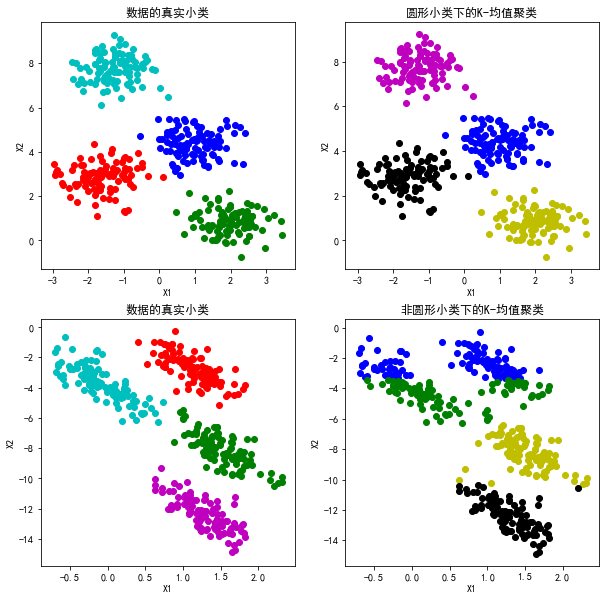

In [2]:
fig=plt.figure(figsize=(10,10))
N=400
K=4
X, y = make_blobs(n_samples=N, centers=K,cluster_std=0.60, random_state=0)
colors = cycle('bgrcmyk')
ax=plt.subplot(221)
for k, col in zip(range(K),colors):
    plt.scatter(X[y == k, 0], X[y == k,1], c=col)
ax.set_title('数据的真实小类')
ax.set_xlabel("X1")
ax.set_ylabel("X2")

KM= KMeans(n_clusters=K, n_jobs = 4, max_iter = 500)
KM.fit(X)
lables = KM.labels_
ax=plt.subplot(222)
for k, col in zip(range(K),colors):
    ax.scatter(X[lables == k, 0], X[lables == k,1], c=col)
ax.set_title('圆形小类下的K-均值聚类')
ax.set_xlabel("X1")
ax.set_ylabel("X2")

rng = np.random.RandomState(12)
X_stretched = np.dot(X, rng.randn(2, 2))
ax=plt.subplot(223)
for k, col in zip(range(K),colors):
    plt.scatter(X_stretched[y == k, 0], X_stretched[y == k,1], c=col)
ax.set_title('数据的真实小类')
ax.set_xlabel("X1")
ax.set_ylabel("X2")

KM= KMeans(n_clusters=K, n_jobs = 4 , max_iter = 500)
KM.fit(X_stretched)
lables = KM.labels_
ax=plt.subplot(224)
for k, col in zip(range(K),colors):
    plt.scatter(X_stretched[lables == k, 0], X_stretched[lables == k,1], c=col)
ax.set_title('非圆形小类下的K-均值聚类')
ax.set_xlabel("X1")
ax.set_ylabel("X2")

代码说明：
（1）第2至4行：生成聚类模拟数据，其中包含4个小类，样本量N=400。
（2）第7至11行：以不同颜色展示数据中真实小类的构成情况。
（3）第13至15行：采用K-均值聚类，将数据聚成4类。并获得聚类解。
（4）第17至21行：可视化聚类解
（5）第23行：定义一个伪随机数生成器对象，后续将用于生成随机数。
（6）第24行：利用伪随机数生成器对象，生成2个来自二元标准高斯分布的随机数
（7）第26至30行：以不同颜色展示数据中真实小类的构成情况。
（8）第32至34行：采用K-均值聚类，将数据聚成4类。并获得聚类解。
（9）第36至40行：可视化聚类解

Text(0.5, 0.92, '混合高斯分布')

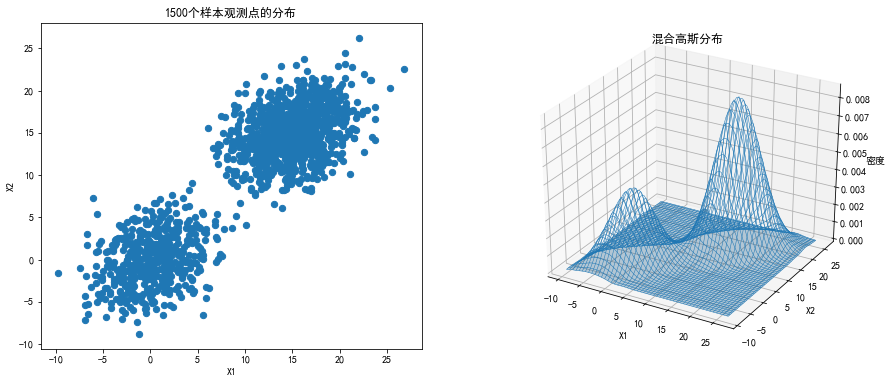

In [3]:
fig=plt.figure(figsize=(15,6))
np.random.seed(123)
N1,N2=500,1000
mu1,cov1,y1=[0,0],[[10,3],[3,10]],np.array([0]*N1)
set1= np.random.multivariate_normal(mu1,cov1,N1) #set1 = multivariate_normal(mean=mu1, cov=cov1,size=N1)
mu2,cov2,y2=[15,15],[[10,3],[3,10]],np.array([1]*N2)
set2=np.random.multivariate_normal(mu2,cov2,N2) #set2 = multivariate_normal(mean=mu2, cov=cov2,size=N2)

X=np.vstack([set1,set2])
y=np.vstack([y1.reshape(N1,1),y2.reshape(N2,1)])
ax=plt.subplot(121)
ax.scatter(X[:,0],X[:,1],s=40)
ax.set_title("%d个样本观测点的分布"%(N1+N2))
ax.set_xlabel("X1")
ax.set_ylabel("X2")

X1,X2= np.meshgrid(np.linspace(X[:,0].min(),X[:,0].max(),100), np.linspace(X[:,1].min(),X[:,1].max(),100))
X0=np.hstack((X1.reshape(len(X1)*len(X2),1),X2.reshape(len(X1)*len(X2),1)))
kernel = gaussian_kde(X.T)   #要求为p*N形状 高斯核密度估计
Z = np.reshape(kernel(X0.T).T, X1.shape)  #得到指定点的密度值
ax = fig.add_subplot(122, projection='3d')
ax.plot_wireframe(X1,X2,Z.reshape(len(X1),len(X2)),linewidth=0.5)
ax.plot_surface(X1,X2,Z.reshape(len(X1),len(X2)),alpha=0.3,rstride =50, cstride = 50)
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("密度")
ax.set_title("混合高斯分布")


In [4]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """用给定的位置和协方差画一个椭圆"""
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    #画出椭圆
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,angle, **kwargs))

代码说明：
（1）第1行：定义用户自定义函数的函数名（draw_ellipse）和形式参数。主要包括椭圆的位置，以及由协方差矩阵决定的椭圆的长短轴和方向。
（2）第4至7行：指定协方差矩阵对椭圆的对应关系。
如果协方差矩阵为2×2的矩阵（一般情况，除非指定聚类变量X_1,X_2的协方差等于0），对协方差矩阵进行奇异值分解。基于U成分计算反正切函数值并转换为度数，作为椭圆方向的角度。基于特征值计算椭圆的长短轴，分别为两个特征值的平方根。
（3）第8至10行：如果协方差矩阵不是2×2的矩阵，即聚类变量X_1,X_2的协方差等于0，椭圆为水平方向放置，椭圆的长短轴分别为两个聚类变量的标准差。
（4）第12，13行：利用for循环和函数Ellipse()依次绘制并叠加三个小椭圆，最终得到各小类的椭圆形状


前五个样本观测分属于两类的概率：
[[1.    0.   ]
 [1.    0.   ]
 [1.    0.   ]
 [0.934 0.066]
 [1.    0.   ]]


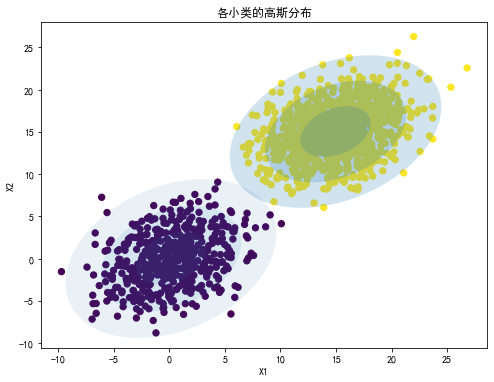

In [5]:
gmm = GaussianMixture(n_components=2,covariance_type='full').fit(X)
labels = gmm.predict(X)
fig=plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=labels, s=40)
w_factor = 0.2 / gmm.weights_.max()
for i in np.unique(labels):
    covar=gmm.covariances_[i]
    pos=gmm.means_[i]
    w=gmm.weights_[i]
    draw_ellipse(pos, covar, alpha=w * w_factor)
plt.xlabel("X1")
plt.ylabel("X2")
plt.title("各小类的高斯分布")
probs = gmm.predict_proba(X)
print("前五个样本观测分属于两类的概率：\n{0}".format(probs[:5].round(3)))

[[ 0.28624542 -0.08579757]
 [-0.08579757  1.28531642]]


Text(0, 0.5, 'X2')

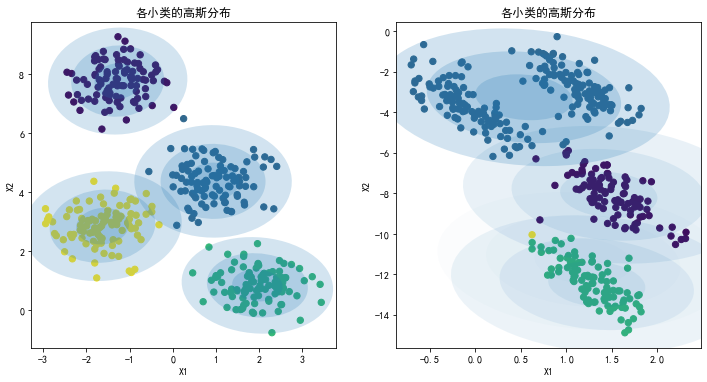

In [6]:
N=400
K=4
X, y = make_blobs(n_samples=N, centers=K,cluster_std=0.60, random_state=0)
gmm = GaussianMixture(n_components=K,covariance_type='full').fit(X)
labels = gmm.predict(X)
fig=plt.figure(figsize=(12,6))
ax=plt.subplot(121)
ax.scatter(X[:, 0], X[:, 1], c=labels, s=40)
w_factor = 0.2 / gmm.weights_.max()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)
ax.set_title("各小类的高斯分布")
ax.set_xlabel("X1")
ax.set_ylabel("X2")

var='tied'
gmm = GaussianMixture(n_components=K,covariance_type=var).fit(X_stretched)
labels = gmm.predict(X_stretched)
ax=plt.subplot(122)
ax.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40)
w_factor = 0.2 / gmm.weights_.max()
if var=='tied':  #四个分布共享合并的协方差阵
    print(gmm.covariances_)
    gmm.covariances_=[gmm.covariances_]*K
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos, covar, alpha=w * w_factor)
ax.set_title("各小类的高斯分布")
ax.set_xlabel("X1")
ax.set_ylabel("X2")

代码说明：
（1）第4至14行：对前述的第一组模拟数据（图11.13左上图数据）进行基于高斯分布的EM聚类，并绘制各小类的椭圆。这里指定4个小类的聚类变量X_1,X_2的协方差矩阵不等。
（2）第16，17行：对前述的第二组模拟数据（图11.13左下数据）进行基于高斯分布的EM聚类，这里指定4个小类的共享协方差矩阵。
（3）第22，23行：为便于统一处理，将共享的协方差矩阵复制K份
